In [5]:
import numpy as np
import netCDF4 as nc
import matplotlib
import matplotlib.pyplot as plt
import datetime
import os
import sys
import oceans.ocfis

In [52]:
year = '2022'
platf_num = '1031'
path = os.path.expanduser('~/Documents/projects/sd-windpower/plot_SD/')
fn = 'adcp-1min-merge-'+year+'-SD'+platf_num+'.nc'
ds = nc.Dataset(path+fn)
print(ds)
vars_load = ['time','latitude','longitude','depth','vel_east','vel_north']
### load adcp data (nc file)
for i in range( len(vars_load) ):
    str_exec = vars_load[i] + "= ds.variables['" + vars_load[i] + "'][:]"
    exec(str_exec)
    print(str_exec)
dtime = np.array([datetime.datetime(int(year),1,1)+datetime.timedelta(seconds=time[i]) for i in range(len(time))])

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    title: Merged files for 2022 SD-1031
    subtitle: Only selected variables for adcp measurements are here. Temporal resolution is ~10-minute.
    dimensions(sizes): depth(50), time(16087), beam(4)
    variables(dimensions): float64 depth(depth), float64 time(time), float64 longitude(time), float64 latitude(time), float64 pitch(time), float64 roll(time), float64 heading(time), float64 vehicle_vel_east(time), float64 vehicle_vel_north(time), float64 vehicle_vel_up(time), float64 bt_vel_east(time), float64 bt_vel_north(time), float64 bt_vel_up(time), float64 vel_east(time, depth), float64 vel_north(time, depth), float64 vel_up(time, depth), float64 error_vel(time, depth), float64 percent_good_4_beam(time, depth), float64 percent_good_3_beam(time, depth), float64 percent_good(time, depth), float64 bt_range(time, beam), float64 bt_cor(time, beam), float64 bt_amp(time, beam), float64 bt_percent_

In [47]:
## interpolate adcp near-surface current in time
#  2022-SD1031 mostly on 10 min intervals
nt = int( (datetime.datetime(2022,11,1)-datetime.datetime(2022,7,16)).total_seconds()/60/10 )
dt_10min = np.array([datetime.datetime(2022,7,16)+datetime.timedelta(minutes=i*10) for i in range(nt)])
time_10min = np.array([(dt_10min[i]-datetime.datetime(int(year),1,1)).total_seconds() for i in range(len(dt_10min))])
print(dt_10min[0],dt_10min[-1])

vel_east_intp = np.nan*np.ones( (len(dt_10min),len(depth)) )
vel_north_intp = vel_east_intp.copy()
for i in range( len(depth) ):
    nanx = np.isnan( vel_east[:,i] );
    vel_east_intp[:,i] = np.interp( time_10min, time[~nanx],vel_east[~nanx,i]);
    vel_north_intp[:,i] = np.interp(time_10min, time[~nanx],vel_north[~nanx,i]);

2022-07-16 00:00:00 2022-10-31 23:50:00


<Figure size 432x288 with 0 Axes>

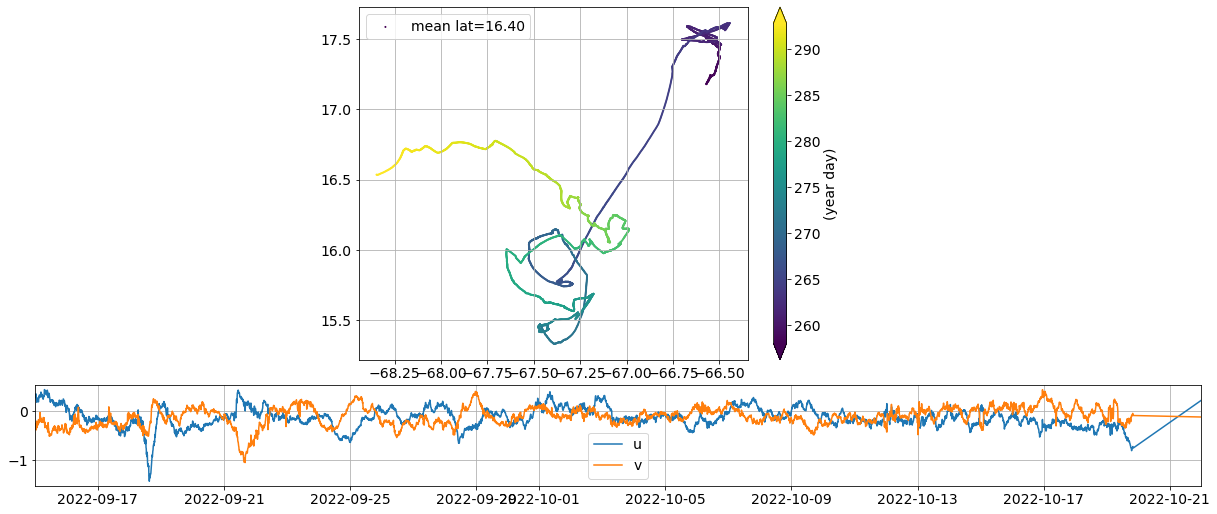

In [105]:
### plot time series
tlim = [datetime.datetime(int(year),9,15), datetime.datetime(int(year),10,22)]
itime_10min = (dt_10min>= tlim[0]) & (dt_10min< tlim[1])
itime = (dtime>= tlim[0]) & (dtime< tlim[1])
iz = 0

plt.clf()
plt.rcParams.update({'font.size': 14})
fig = plt.figure(figsize=(18,7))
ax1 = fig.add_axes([0.3,0.25,0.3,0.7])
sc = ax1.scatter( longitude[itime], latitude[itime], c=time[itime]/86400+1, s=1, label='mean lat={:.2f}'.format(np.mean(latitude[itime])))
ax1.grid(); ax1.legend()
axf = fig.add_axes([0.62,0.25,0.01,0.7])
axf = plt.colorbar(sc,orientation='vertical',cax=axf,extend='both')
axf.set_label('(year day)',fontsize=14)
ax2 = fig.add_axes([0.05,0,0.9,0.2])
ax2.plot(dt_10min[itime_10min], vel_east_intp[itime_10min,iz],label='u')
ax2.plot(dt_10min[itime_10min], vel_north_intp[itime_10min,iz],label='v')
ax2.set_xlim(tlim)
ax2.grid(); ax2.legend()

fig.savefig('uv('+str(depth[iz])+'m)-10min_'+year+'-SD'+platf_num+'_'+tlim[0].strftime('%Y%m%d')+'-'+tlim[1].strftime('%Y%m%d')+'.png',\
            dpi=300,bbox_inches='tight')

/var/folders/hq/8x0c_cvs4651pwh9kv6t7_zc0000gq/T/ipykernel_70387/4124074175.py:15: UserWarning: Legend does not support handles for str instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#controlling-the-legend-entries
  plt.legend('cw','ccw')


<Figure size 432x288 with 0 Axes>

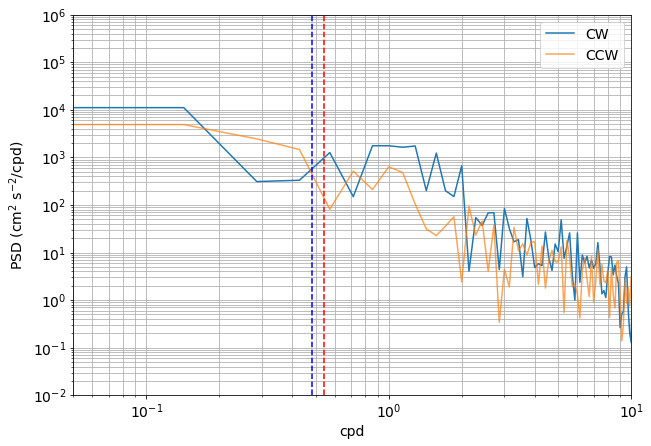

In [89]:
### compute and plot rotary spectra for a selected time
uc = vel_east_intp[itime_10min,0] + 1j*vel_north_intp[itime_10min,0]
puv, quv, cw, ccw, F = oceans.ocfis.spec_rot(uc.real, uc.imag)
# print(puv.shape, quv.shape, cw.shape, ccw.shape, F.shape)
f_inert = 24/44.18
f_M2 = 24/(24+50/60)/2
### plot
plt.clf()
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots()
plt.gcf().set_size_inches(10,7)

plt.loglog(F*6*24, cw, label='CW') 
plt.loglog(F*6*24, ccw,label='CCW',alpha=0.7)
plt.legend('cw','ccw')
plt.xlabel('cpd')
plt.ylabel('PSD (cm$^{2}$ s$^{-2}$/cpd)')
ylim = [1e-2,1e6]
plt.loglog([f_inert, f_inert],[ylim[0],ylim[1]],'--',color='r')
plt.loglog([f_M2, f_M2],[ylim[0],ylim[1]],'--',color='b')
plt.xlim([5e-2,1e1])
plt.ylim(ylim)
plt.grid(True, which='both')
plt.legend()

fig.savefig('rotspec_uv('+str(depth[iz])+'m)-10min_'+year+'-SD'+platf_num+'_'+tlim[0].strftime('%Y%m%d')+'-'+tlim[1].strftime('%Y%m%d')+'.png',\
            dpi=300,bbox_inches='tight')